In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Path to spykes.py
import sys
sys.path.insert(0, '../spykes/')

# Set the style
plt.style.use('./../spykes/mpl_styles/spykes.mplstyle')

# Start by simulating a neuron
We will load real data later in this tutorial

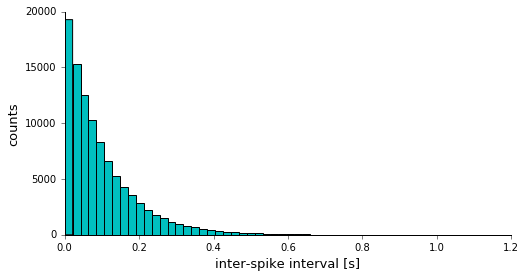

In [2]:
n_spikes = 100000
firing_rate = 10. # [spks/s]
av_inter_spk_interval = 1/firing_rate # average interspike interval [ms]

# Simulate
spike_times = np.cumsum(np.random.exponential(av_inter_spk_interval,n_spikes))

# Plot distribitution of inter-spike intervals
plt.figure(figsize=(8,4))
plt.hist(np.diff(spike_times), 50, color = 'c')
plt.xlabel('inter-spike interval [s]')
plt.ylabel('counts')

plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')  
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Load spykes package

In [3]:
import spykes as spy

# Spyke class
### Instantiate neuron

In [4]:
neuron_id ='faker'   #choose name for neuron (not necessary)
neuron = spy.Spyke(spike_times, neuron_id)
neuron

# Spyke.firingrate
does it have the firing rate we simulated?


In [5]:
firing_rate = neuron.firingrate

print 'neuron %s has a firing rate of %.2f spks/s' % (neuron.name, neuron.firingrate)

neuron faker has a firing rate of 10.04 spks/s


# Spyke.get_psth
let's try a psth , we don't have an event....<br>
we can align it to spike times:


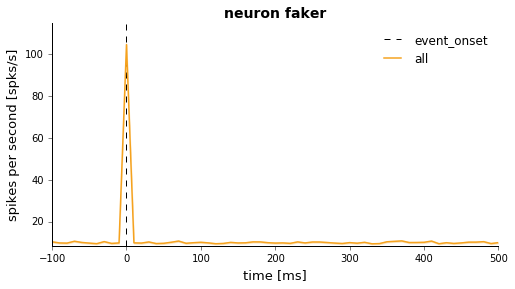

In [6]:
neuron.get_psth(spike_times[1000:10000]);

hmmm that makes sense <br>
# Let's simulate an event

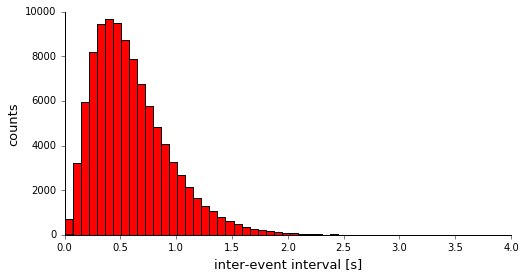

In [7]:
event_times = np.cumsum(np.random.gamma(3,0.2,100000))

# Plot distribitution of inter-event intervals
plt.figure(figsize=(8,4))
plt.hist(np.diff(event_times), 50, color = 'r')
plt.xlabel('inter-event interval [s]')
plt.ylabel('counts')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')  
plt.show()

now let's look at the psth for this event

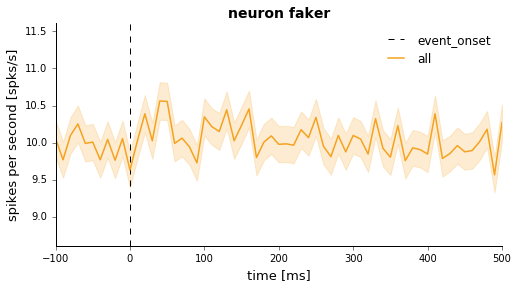

In [8]:
neuron.get_psth(event_times);

the simulated neuron doesn't seem to be tuned to this independent event.... good

# Let's load some real data

In [9]:
# Packages for reading the data
import h5py
import deepdish as dd
import os
from skimage import io

# Load data
Monkey  = 'M1' #choose monkey
h5path = '/Volumes/JUICE/lab projects/V4_CNN/V4pydata/H5data/' + Monkey
fname = os.listdir(h5path)
fname = [session for session in fname if '.h5' in session]
thisfile = fname[0] #choose a session
dat = dd.io.load(h5path+'/'+ thisfile) #load

print 'loaded session: %s of monkey %s' % (thisfile[:-3], Monkey)
print "We have a dictionary with 2 fields: %s" % str(dat.keys())
print "and a total of %d neurons" % np.size(dat['spikes'].keys())

#let's get spikes and the list of neuron ids
spikes = dat['spikes']
neuron_list = dat['spikes'].keys()

loaded session: bucky090910 of monkey M1
We have a dictionary with 2 fields: ['eyes', 'spikes']
and a total of 142 neurons


In [10]:
#let's look at neuron number 50, for instance ;)
neuron_id = neuron_list[50]
spikes = dat['spikes'][neuron_id]

#instantiate neuron
neuron = spy.Spyke(spikes, name = neuron_id)

what's its firing rate?

In [11]:
print 'neuron %s has a firing rate of %.2f spks/s' % (neuron_id, neuron.firingrate)

neuron 3301 has a firing rate of 30.20 spks/s


now we want to plot a PSTH <br> let's see what are our options for events

In [12]:
print dat['eyes'][0].keys()

['in_sac_blink', 'imname', 'fix_offset', 'fix_offset_col', 'badfix', 'trial', 'out_sac_blink', 'out_sac_dur', 'col', 'fixation', 'out_sac_pkvel', 'in_sac_dur', 'impath', 'fix_onset', 'fix_offset_row', 'fix_onset_col', 'in_sac_pkvel', 'fix_onset_row', 'row']


let's use `fix_onset`, i.e. fixation onset

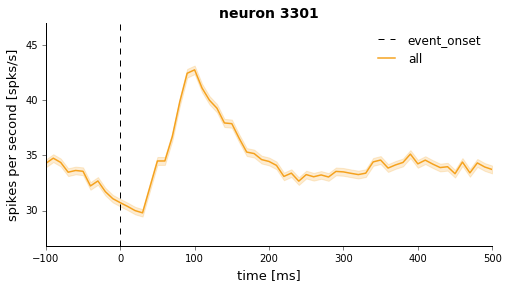

In [13]:
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
neuron.get_psth(fix_onset_times);

how about about a raster plot?

# Spyke.get_raster

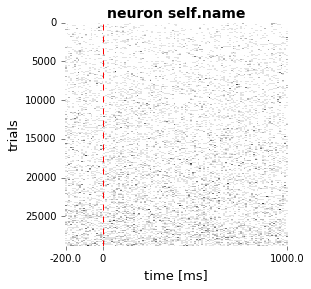

In [14]:
neuron.get_raster(fix_onset_times, window=[-200,1000]);

# Let's look at specific trials
First we get features

In [15]:
for_features = dat['eyes'][0].keys()
for i in ['imname','impath']: for_features.remove(i) 
features = {}
for feat in for_features:
    features[feat] = np.array([dat['eyes'][fix][feat] for fix in dat['eyes']])  
    
features['fix_duration'] = features['fix_offset']-features['fix_onset']
features['in_screen'] = np.all((features['col']>=1, features['col']<=1024, \
                                features['row']>=1, features['row']<=768), axis=0)
print features.keys()

['in_sac_blink', 'in_screen', 'fix_onset_row', 'fix_offset', 'fix_offset_col', 'out_sac_blink', 'out_sac_dur', 'fix_onset_col', 'fix_duration', 'trial', 'out_sac_pkvel', 'in_sac_dur', 'fix_onset', 'fixation', 'fix_offset_row', 'badfix', 'col', 'in_sac_pkvel', 'row']


Next we impose restrictions on those features <br>
For example: let's look at fixations inside the screen vs outside the screen

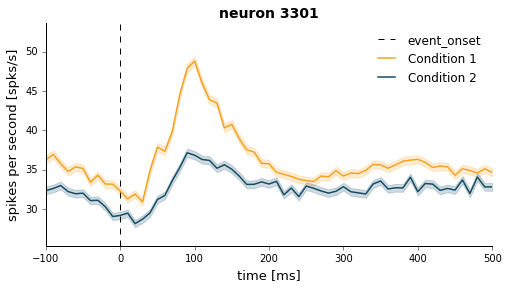

Condition 1: {'in_screen': [1]}; 14591 trials
Condition 2: {'in_screen': [0]}; 14591 trials


In [16]:
conditions = {}
conditions[0]= {}
conditions[0]['in_screen'] = [1]

conditions[1]= {}
conditions[1]['in_screen'] = [0]

neuron.get_psth(features['fix_onset'], features, conditions);

And we can add conditions:

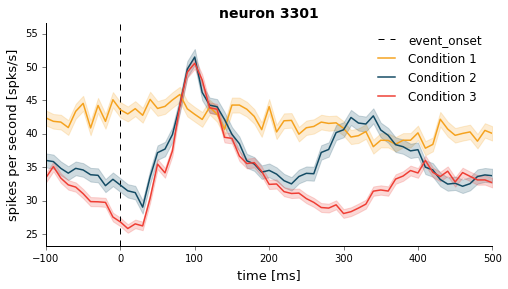

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 6903 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 6903 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [17]:
conditions = {}
conditions[0]= {}
conditions[0]['in_screen'] = [1]
conditions[0]['fix_duration'] = [0.0, 0.08] # Fixation duration between [0, 80] ms

conditions[1]= {}
conditions[1]['in_screen'] = [1]
conditions[1]['fix_duration'] = [0.08, 0.2] # Fixation duration between [80, 200] ms

conditions[2]= {}
conditions[2]['in_screen'] = [1]
conditions[2]['fix_duration'] = [0.2, 1.0] # Fixation duration between [200, 1000] ms

neuron.get_psth(features['fix_onset'], features, conditions);


Let's look at a bigget time window

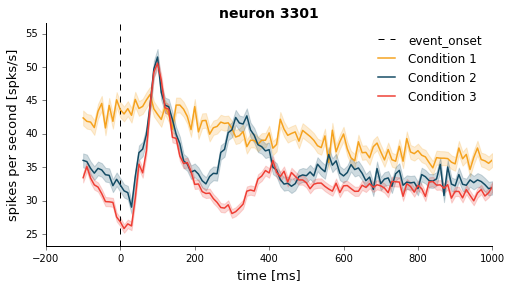

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 6903 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 6903 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [18]:
neuron.get_psth(features['fix_onset'], \
                features, conditions, window = [-100,1000]);

Default binsizes are 10 ms, let's try with 50 ms

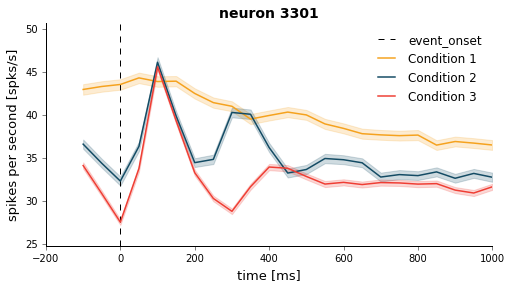

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 6903 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 6903 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [19]:
neuron.get_psth(features['fix_onset'], features, conditions, \
                window = [-100,1000], binsize=50);

And some rasters for the same conditions

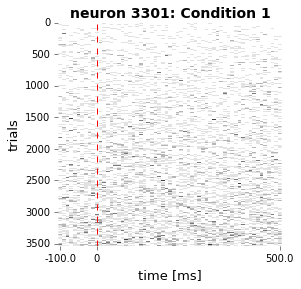

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}


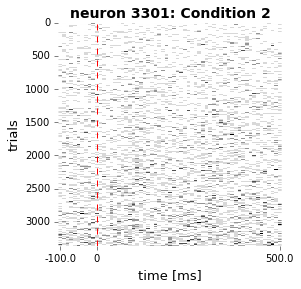

Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}


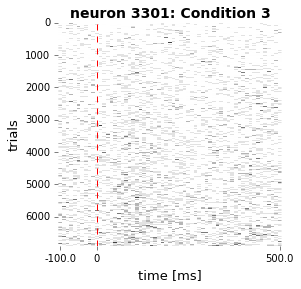

Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}


In [20]:
neuron.get_raster(features['fix_onset'], features, conditions);

# Let's see what Spyke.get_psth outputs:

In [21]:
psth = neuron.get_psth(features['fix_onset'], features, conditions, \
                window = [-100,1000], binsize=50, plot=False);
print psth.keys()

['data', 'window', 'conditions', 'binsize']


In [22]:
for i in psth:
    if i not in ['data','conditions']:
        print '%s = %s' % (i, str(psth[i]))
print 'Conditions:'
for i in psth['conditions']:
    print psth['conditions'][i] 

window = [-100.0, 1000.0]
binsize = 50
Conditions:
{'fix_duration': [0.0, 0.08], 'in_screen': [1]}
{'fix_duration': [0.08, 0.2], 'in_screen': [1]}
{'fix_duration': [0.2, 1.0], 'in_screen': [1]}


# Spyke.plot_psth

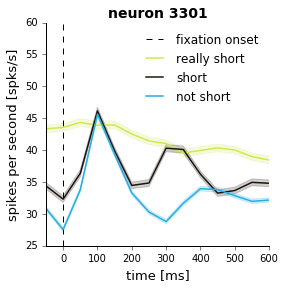

In [23]:
neuron.plot_psth(psth, event_name = 'fixation onset', \
                 condition_names=['really short','short','not short'], \
                 xlim = [-50,600], ylim=[25,60], figsize=(4,4),\
                 colors = ['#D1E751', '#1C140D', '#26ADE4'])

# Let's see what Spyke.get_raster outputs

In [24]:
rasters = neuron.get_raster(features['fix_onset'], features, conditions, plot=False);
print rasters.keys()

['data', 'window', 'conditions', 'binsize']


In [25]:
for i in rasters:
    if i not in ['data','conditions']:
        print '%s = %s' % (i, str(rasters[i]))
print 'Conditions:'
for i in rasters['conditions']:
    print rasters['conditions'][i] 

window = [-100.0, 500.0]
binsize = 10
Conditions:
{'fix_duration': [0.0, 0.08], 'in_screen': [1]}
{'fix_duration': [0.08, 0.2], 'in_screen': [1]}
{'fix_duration': [0.2, 1.0], 'in_screen': [1]}


# Spyke.plot_raster

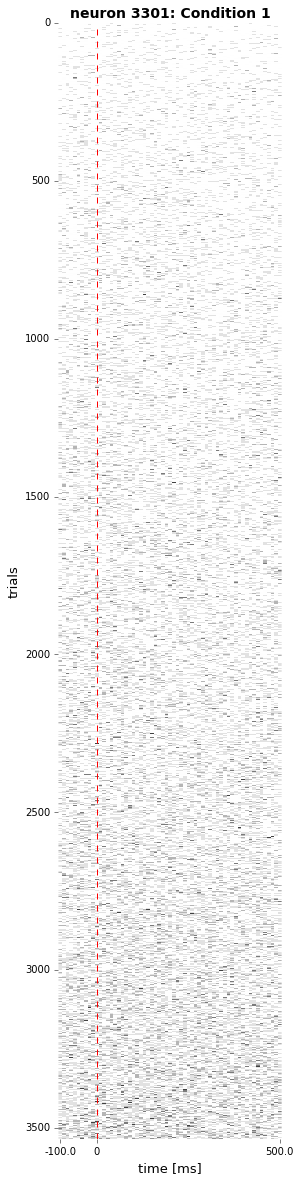

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}


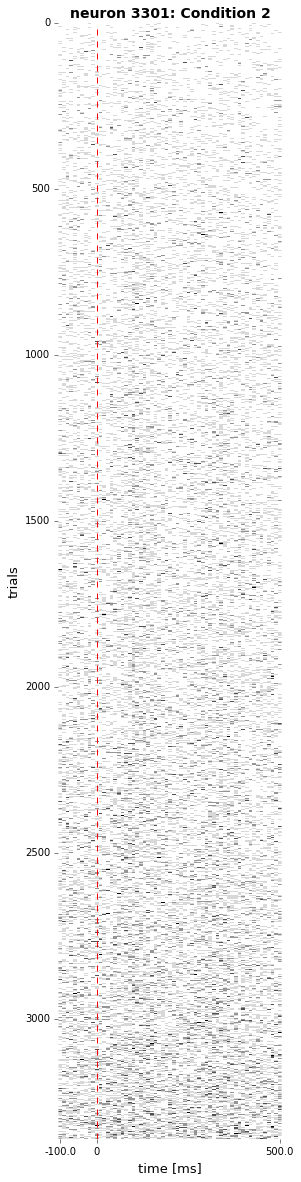

Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}


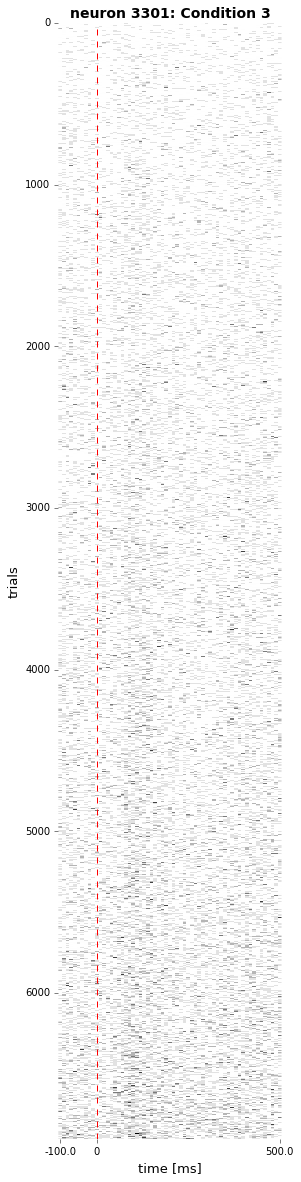

Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}


In [26]:
neuron.plot_raster(rasters, figsize=(4,20), sort=True)